# final notebook

## imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit


#Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

## file loading

In [5]:
#Load files
df_rel = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
df_bn_bk = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
df_pos_bk = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
df_vis = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv') 
df_cal = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
sub_template = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')


In [6]:
df_vis['visit_date'] = pd.to_datetime(df_vis['show_date'])
df_cal['show_date'] = pd.to_datetime(df_cal['show_date'])

df_bn_bk['show_date'] = pd.to_datetime(df_bn_bk['show_datetime']).dt.floor('D')
df_pos_bk['show_date'] = pd.to_datetime(df_pos_bk['show_datetime']).dt.floor('D')

bn_agg = df_bn_bk.groupby(['book_theater_id', 'show_date'])['tickets_booked'].sum().reset_index()
bn_agg.rename(columns={'tickets_booked': 'online_tickets', 'show_date': 'visit_date'}, inplace=True)

pos_merged = df_pos_bk.merge(df_rel, on='cine_theater_id', how='inner')
pos_agg = pos_merged.groupby(['book_theater_id', 'show_date'])['tickets_sold'].sum().reset_index()
pos_agg.rename(columns={'tickets_sold': 'pos_tickets', 'show_date': 'visit_date'}, inplace=True)

## master dataframe creation

In [7]:
master_df = df_vis[['book_theater_id', 'visit_date', 'audience_count']].copy()

master_df = master_df.merge(bn_agg, on=['book_theater_id', 'visit_date'], how='left')
master_df = master_df.merge(pos_agg, on=['book_theater_id', 'visit_date'], how='left')
master_df = master_df.merge(df_cal, left_on='visit_date', right_on='show_date', how='left')

master_df['online_tickets'].fillna(0, inplace=True)
master_df['pos_tickets'].fillna(0, inplace=True)

master_df.drop(columns=['show_date'], inplace=True, errors='ignore')
print(f"Master DF Shape: {master_df.shape}")

Master DF Shape: (214046, 6)


## EDA

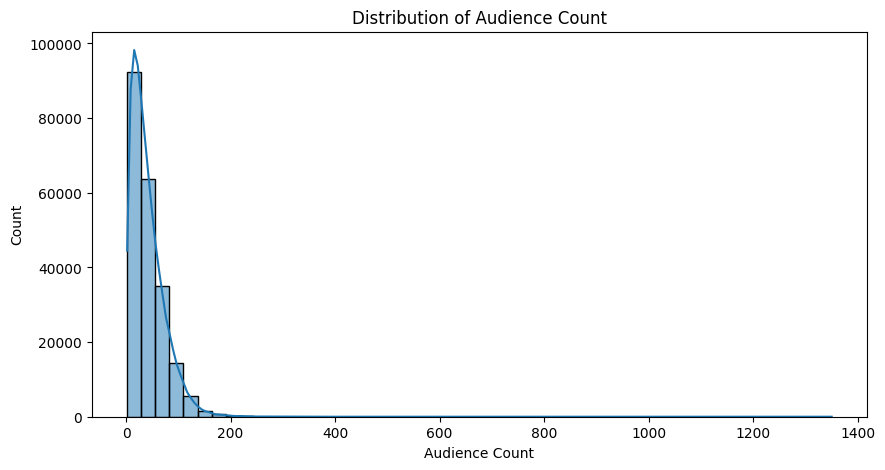

Zero audience days: 0


In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(master_df['audience_count'], bins=50, kde=True)
plt.title("Distribution of Audience Count")
plt.xlabel("Audience Count")
plt.show()

print(f"Zero audience days: {(master_df['audience_count'] == 0).sum()}")
#no. of 0-visit days

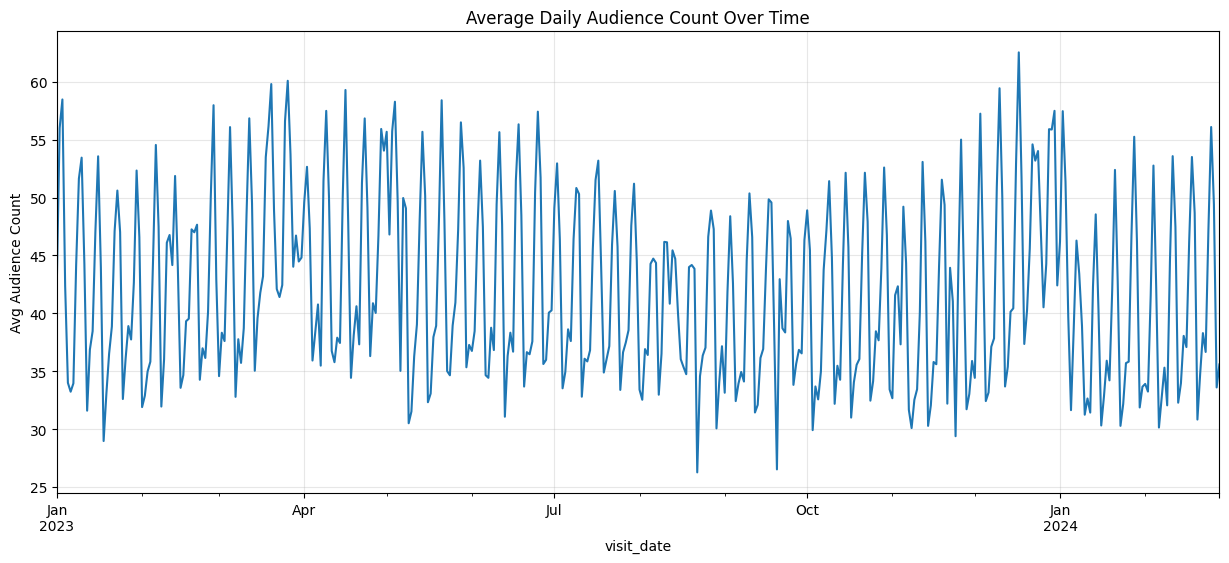

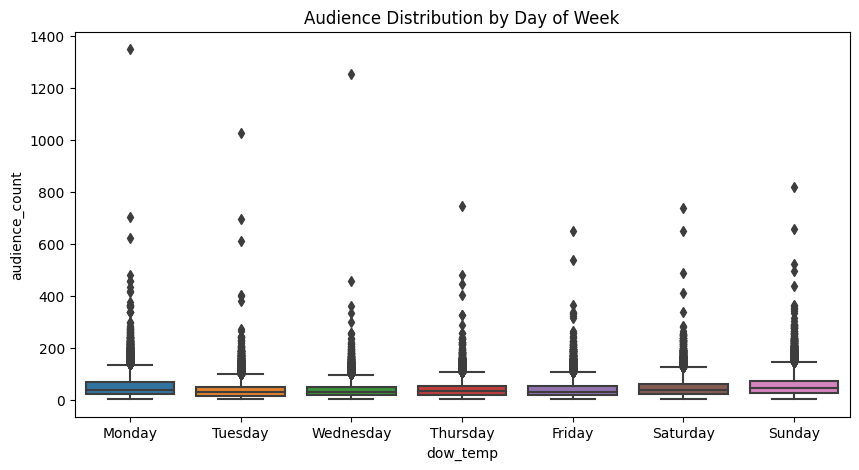

In [9]:
daily_trend = master_df.groupby('visit_date')['audience_count'].mean()
#mean audience on a particular day for all theatres combined
plt.figure(figsize=(15, 6))
daily_trend.plot()
plt.title("Average Daily Audience Count Over Time")
plt.ylabel("Avg Audience Count")
plt.grid(True, alpha=0.3)
plt.show()

#Weekly seasonality
master_df['dow_temp'] = master_df['visit_date'].dt.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='dow_temp', y='audience_count', data=master_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Audience Distribution by Day of Week")
plt.show()

## Feature eengineering

In [10]:
master_df.sort_values(['book_theater_id', 'visit_date'], inplace=True)

#Date Parts
master_df['day'] = master_df['visit_date'].dt.day
master_df['month'] = master_df['visit_date'].dt.month
master_df['dow'] = master_df['visit_date'].dt.dayofweek
master_df['is_weekend'] = (master_df['dow'] >= 5).astype(int)



In [11]:
#Lag Features
lags = [7, 14, 28]
for lag in lags:
    master_df[f'lag_{lag}'] = master_df.groupby('book_theater_id')['audience_count'].shift(lag)

#Rolling Features
windows = [7, 14]
for w in windows:
    master_df[f'roll_mean_{w}'] = master_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window=w).mean()

#Encoding Theater ID
le = LabelEncoder()
master_df['theater_id_enc'] = le.fit_transform(master_df['book_theater_id'])

master_df.fillna(0, inplace=True)
print("Features created.")

Features created.


## Correlation check

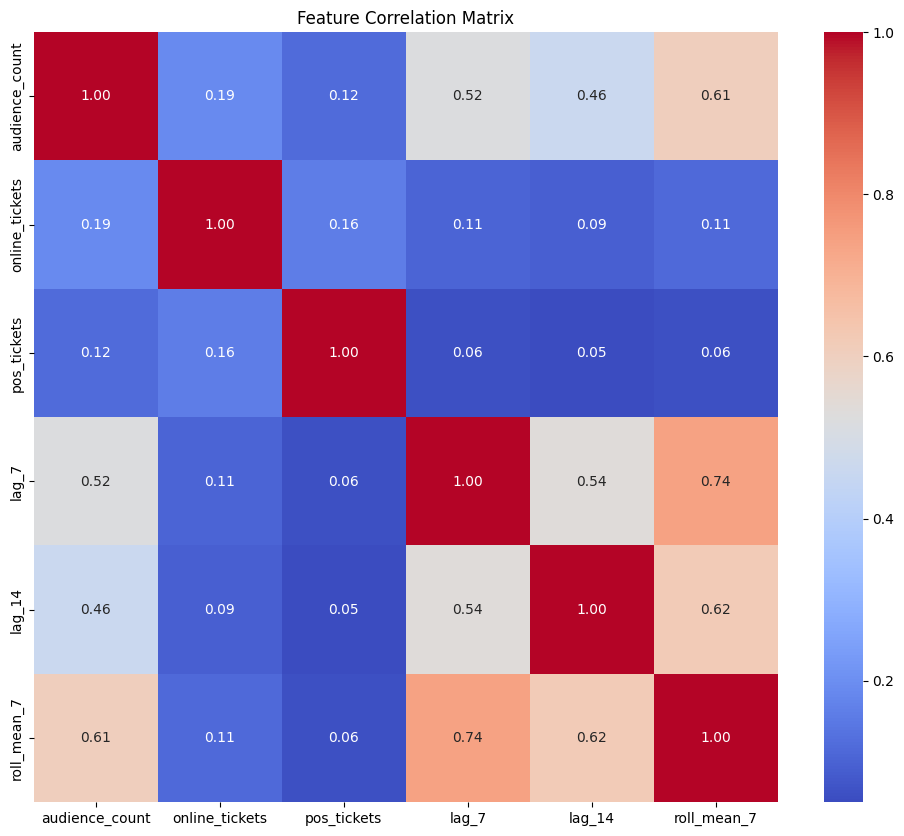

In [12]:
plt.figure(figsize=(12, 10))
corr = master_df[['audience_count', 'online_tickets', 'pos_tickets', 'lag_7', 'lag_14', 'roll_mean_7']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## Time-Based splitting

In [13]:
split_date = master_df['visit_date'].max() - pd.DateOffset(months=2)

train_df = master_df[master_df['visit_date'] < split_date]
val_df = master_df[master_df['visit_date'] >= split_date]

print(f"Train range: {train_df['visit_date'].min().date()} to {train_df['visit_date'].max().date()}")
print(f"Val range:   {val_df['visit_date'].min().date()} to {val_df['visit_date'].max().date()}")

features = ['theater_id_enc', 'day', 'month', 'dow', 'is_weekend',
            'online_tickets', 'pos_tickets',
            'lag_7', 'lag_14', 'lag_28', 
            'roll_mean_7', 'roll_mean_14']

X_train = train_df[features]
y_train = train_df['audience_count']
X_val = val_df[features]
y_val = val_df['audience_count']

print(f"Training on {len(features)} features.")

Train range: 2023-01-01 to 2023-12-27
Val range:   2023-12-28 to 2024-02-28
Training on 12 features.


## Model training

In [14]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['LightGBM', 'XGBoost', 'RandomForest'])
    #choosing a model
    
    #hyperparameters based on the chosen model
    if model_type == 'LightGBM':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 60),
            'n_jobs': -1, 'verbose': -1, 'random_state': 42
        }
        model = lgb.LGBMRegressor(**params)
        
    elif model_type == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_jobs': -1, 'random_state': 42
        }
        model = xgb.XGBRegressor(**params)
        
    else: #RandomForest
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'n_jobs': -1, 'random_state': 42
        }
        model = RandomForestRegressor(**params)

    #evaluation using Time-Series Split (cross-val)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        # Create splits
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train and Score
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(r2_score(y_val, preds))
        
    return np.mean(scores)



In [15]:
#Optimization started
print("Starting tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15) 


best_trial = study.best_trial
best_model_name = best_trial.params['model_type']
best_params = best_trial.params
print(f"Best Model: {best_model_name}")
print(f"Best R2 Score: {best_trial.value:.4f}")

#Final model creation
if best_model_name == 'LightGBM':
    p = {k: v for k, v in best_params.items() if k != 'model_type'}
    #adding fixed params
    p['n_jobs'] = -1; p['verbose'] = -1; p['random_state'] = 42
    final_model = lgb.LGBMRegressor(**p)
    
elif best_model_name == 'XGBoost':
    p = {k: v for k, v in best_params.items() if k != 'model_type'}
    p['n_jobs'] = -1; p['random_state'] = 42
    final_model = xgb.XGBRegressor(**p)
    
else: # RandomForest
    p = {k: v for k, v in best_params.items() if k != 'model_type'}
    p['n_jobs'] = -1; p['random_state'] = 42
    final_model = RandomForestRegressor(**p)

#Store in dictionary
models = {"Best_Tuned_Model": final_model}
best_model = final_model 
best_score = best_trial.value

[I 2025-12-11 19:17:35,546] A new study created in memory with name: no-name-dcaf2c94-b706-4c69-a711-d0270a1fe045


Starting tuning...


[I 2025-12-11 19:17:41,224] Trial 0 finished with value: 0.3982757576156278 and parameters: {'model_type': 'XGBoost', 'n_estimators': 807, 'learning_rate': 0.03367171404271584, 'max_depth': 5}. Best is trial 0 with value: 0.3982757576156278.
[I 2025-12-11 19:17:53,680] Trial 1 finished with value: 0.3270177055036336 and parameters: {'model_type': 'LightGBM', 'n_estimators': 1191, 'learning_rate': 0.04271994749232921, 'num_leaves': 47}. Best is trial 0 with value: 0.3982757576156278.
[I 2025-12-11 19:18:10,579] Trial 2 finished with value: 0.23161563613176847 and parameters: {'model_type': 'LightGBM', 'n_estimators': 1831, 'learning_rate': 0.08023865346922876, 'num_leaves': 45}. Best is trial 0 with value: 0.3982757576156278.
[I 2025-12-11 19:18:46,657] Trial 3 finished with value: 0.46832672514544305 and parameters: {'model_type': 'RandomForest', 'n_estimators': 188, 'max_depth': 10}. Best is trial 3 with value: 0.46832672514544305.
[I 2025-12-11 19:19:04,389] Trial 4 finished with val

Best Model: RandomForest
Best R2 Score: 0.4734


In [16]:
'''
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42, max_depth=20),
    "LightGBM": lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.02, num_leaves=50, random_state=42, n_jobs=-1, verbose=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=2000, learning_rate=0.02, max_depth=8, random_state=42, n_jobs=-1)
}

results = {}
best_score = -np.inf
best_model_name = ""
best_model = None

'''

'\nmodels = {\n    "Random Forest": RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42, max_depth=20),\n    "LightGBM": lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.02, num_leaves=50, random_state=42, n_jobs=-1, verbose=-1),\n    "XGBoost": xgb.XGBRegressor(n_estimators=2000, learning_rate=0.02, max_depth=8, random_state=42, n_jobs=-1)\n}\n\nresults = {}\nbest_score = -np.inf\nbest_model_name = ""\nbest_model = None\n\n'

In [18]:
'''
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = r2_score(y_val, preds)
    results[name] = score
    print(f"{name} Validation R2: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model

print(f"\n>>> Best Model: {best_model_name} with R2: {best_score:.4f}")
'''

'\nfor name, model in models.items():\n    print(f"Training {name}...")\n    model.fit(X_train, y_train)\n    preds = model.predict(X_val)\n    score = r2_score(y_val, preds)\n    results[name] = score\n    print(f"{name} Validation R2: {score:.4f}")\n    \n    if score > best_score:\n        best_score = score\n        best_model_name = name\n        best_model = model\n\nprint(f"\n>>> Best Model: {best_model_name} with R2: {best_score:.4f}")\n'

## Visualization

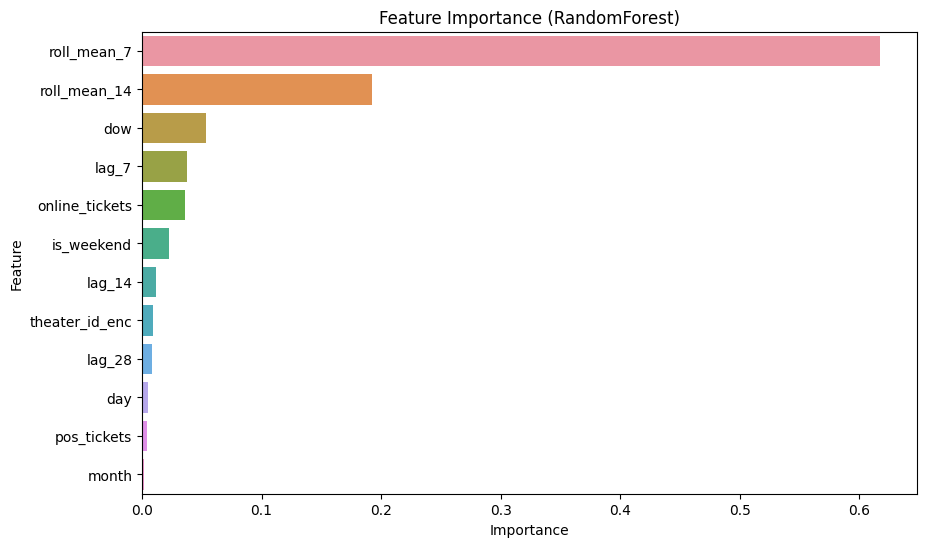

In [19]:
#feature importances from the best model
importances = best_model.feature_importances_
feature_names = X_train.columns

#dataframe for plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15)) # Top 15 features
plt.title(f"Feature Importance ({best_model_name})")
plt.show()

In [20]:
#making final predictions
preds_best = best_model.predict(X_val)

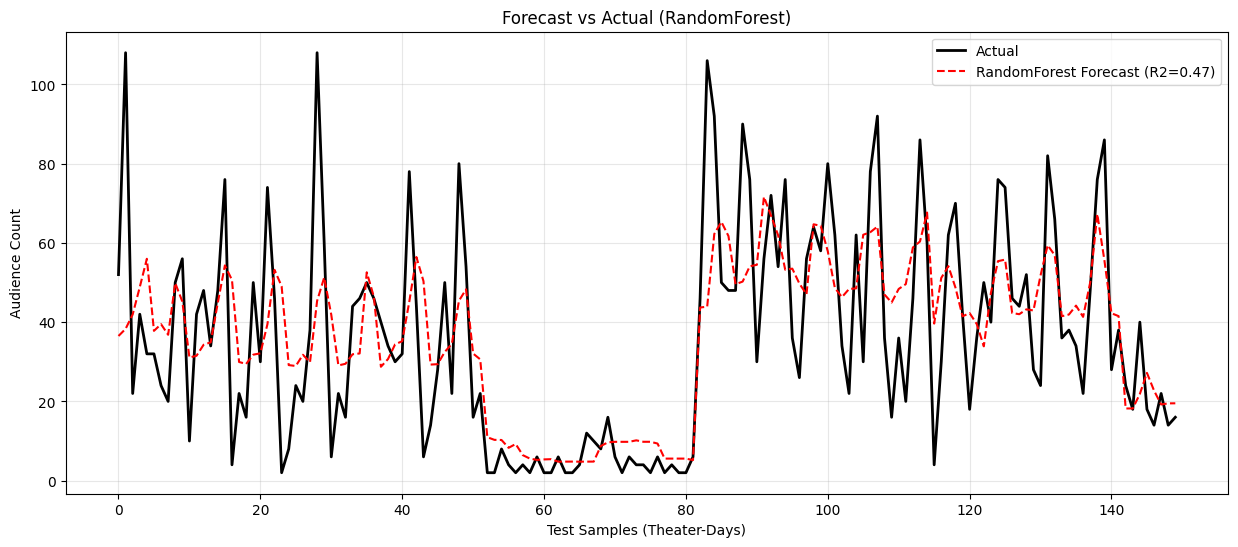

In [21]:

plt.figure(figsize=(15, 6))
limit = 150
plt.plot(y_val.values[:limit], label='Actual', color='black', linewidth=2)
plt.plot(preds_best[:limit], label=f'{best_model_name} Forecast (R2={best_score:.2f})', color='red', linestyle='--', linewidth=1.5)

plt.title(f"Forecast vs Actual ({best_model_name})")
plt.xlabel("Test Samples (Theater-Days)")
plt.ylabel("Audience Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## making submissions

In [22]:
#Parse Submission IDs
test_df = sub_template[['ID']].copy()
test_df['book_theater_id'] = test_df['ID'].apply(lambda x: x.rsplit('_', 1)[0])
test_df['visit_date'] = pd.to_datetime(test_df['ID'].apply(lambda x: x.rsplit('_', 1)[1]))

#Merge Basic Features
test_df['day'] = test_df['visit_date'].dt.day
test_df['month'] = test_df['visit_date'].dt.month
test_df['dow'] = test_df['visit_date'].dt.dayofweek
test_df['is_weekend'] = (test_df['dow'] >= 5).astype(int)

# Encode Theater IDs
test_df['theater_id_enc'] = test_df['book_theater_id'].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Merge Booking Info
test_df = test_df.merge(bn_agg, on=['book_theater_id', 'visit_date'], how='left')
test_df = test_df.merge(pos_agg, on=['book_theater_id', 'visit_date'], how='left')
test_df.fillna(0, inplace=True)

In [23]:

# Construct Lag Features for Test Set
print("Constructing test lags...")
for col in ['lag_7', 'lag_14', 'lag_28', 'roll_mean_7', 'roll_mean_14']:
    last_known = master_df.sort_values('visit_date').groupby('book_theater_id')[col].tail(1)
    mapping = dict(zip(master_df.sort_values('visit_date').groupby('book_theater_id').tail(1)['book_theater_id'], last_known))
    test_df[col] = test_df['book_theater_id'].map(mapping).fillna(0)

# Retrain Best Model on Full Data & Predict
print(f"Retraining {best_model_name} on full dataset...")
X_full = master_df[features]
y_full = master_df['audience_count']

best_model.fit(X_full, y_full)

final_preds = best_model.predict(test_df[features])

# Save
submission = sub_template[['ID']].copy()
submission['audience_count'] = np.round(final_preds).astype(int)
submission['audience_count'] = submission['audience_count'].clip(lower=0)

submission.to_csv('submission.csv', index=False)
print(f"Submission saved as 'submission.csv' using {best_model_name}")
print(submission.head())

Constructing test lags...
Retraining RandomForest on full dataset...
Submission saved as 'submission.csv' using RandomForest
                      ID  audience_count
0  book_00001_2024-03-01              33
1  book_00001_2024-03-02              41
2  book_00001_2024-03-03              47
3  book_00001_2024-03-04              40
4  book_00001_2024-03-06              30
